# Knowledge graph link prediction with DistMult

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/link-prediction/distmult-link-prediction.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/link-prediction/distmult-link-prediction.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

This notebook reproduces the experiments done in the paper that introduced the DistMult algorithm: Embedding Entities and Relations for Learning and Inference in Knowledge Bases, Bishan Yang, Scott Wen-tau Yih, Xiaodong He, Jianfeng Gao and Li Deng, ICLR 2015. https://arxiv.org/pdf/1412.6575

In table 2, the paper reports 2 metrics measured on the WN18 and FB15K datasets (and FB15k-401): MRR (mean reciprocal rank) and Hits at 10. These are computed as "filtered", where known edges (in the train, test or validation sets) are ignored when computing ranks.

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [3]:
from stellargraph import datasets, utils
from tensorflow.keras import callbacks, optimizers, losses, metrics, regularizers, Model
import numpy as np
import pandas as pd

from stellargraph.mapper import KGTripleGenerator
from stellargraph.layer import DistMult

from IPython.display import HTML

## Initialisation

We need to set up our model parameters, like the number of epochs to train for, and the dimension of the embedding vectors we compute for each node and for each edge type. 

The evaluation is performed in three steps:

1. Load the data
2. Train a model
3. Evaluate the model

On pages 4 and 5, the paper describes their implementation details. The paper says that it uses:

- the AdaGrad optimiser for 100 (for FB15k) or 300 epochs (for WN18)
- an embedding dimension of 100
- samples 2 corrupted edges per true edge
- unit normalization of each entity embedding vector after each epoch: this is not currently supported by TensorFlow ([#33755](https://github.com/tensorflow/tensorflow/issues/33755)), and so may explain the slightly poorer MRR metrics on WN18

In [4]:
epochs = 300
embedding_dimension = 100
negative_samples = 2

## WN18

The paper uses the WN18 and FB15k datasets for validation. These datasets are not good for evaluating algorithms because they contain "inverse relations", where `(s, r1, o)` implies `(o, r2, s)` for a pair of relation types `r1` and `r2` (for instance, `_hyponym` ("is more specific than") and `_hypernym` ("is more general than") in WN18), however, they work fine to demonstrate StellarGraph's functionality, and are appropriate to compare against the published results.

### Load the data

The dataset comes with a defined train, test and validation split, each consisting of subject, relation, object triples. We can load a `StellarGraph` object with all of the triples, as well as the individual splits as Pandas DataFrames, using the `load` method of the `WN18` dataset.

(See [the "Loading from Pandas" demo](../basics/loading-pandas.ipynb) for details on how data can be loaded.)

In [5]:
wn18 = datasets.WN18()
display(HTML(wn18.description))
wn18_graph, wn18_train, wn18_test, wn18_valid = wn18.load()

In [6]:
print(wn18_graph.info())

StellarDiGraph: Directed multigraph
 Nodes: 40943, Edges: 151442

 Node types:
  default: [40943]
    Features: none
    Edge types: default-_also_see->default, default-_derivationally_related_form->default, default-_has_part->default, default-_hypernym->default, default-_hyponym->default, ... (13 more)

 Edge types:
    default-_hyponym->default: [37221]
    default-_hypernym->default: [37221]
    default-_derivationally_related_form->default: [31867]
    default-_member_meronym->default: [7928]
    default-_member_holonym->default: [7928]
    default-_part_of->default: [5148]
    default-_has_part->default: [5142]
    default-_member_of_domain_topic->default: [3341]
    default-_synset_domain_topic_of->default: [3335]
    default-_instance_hyponym->default: [3150]
    default-_instance_hypernym->default: [3150]
    default-_also_see->default: [1396]
    default-_verb_group->default: [1220]
    default-_member_of_domain_region->default: [983]
    default-_synset_domain_region_of->defa

### Train a model

The DistMult algorithm consists of some embedding layers and a scoring layer, but the `DistMult` object means these details are invisible to us. The `DistMult` model consumes "knowledge-graph triples", which can be produced in the appropriate format using `KGTripleGenerator`.

In [7]:
wn18_gen = KGTripleGenerator(
    wn18_graph, batch_size=len(wn18_train) // 10  # ~10 batches per epoch
)

wn18_distmult = DistMult(
    wn18_gen,
    embedding_dimension=embedding_dimension,
    embeddings_regularizer=regularizers.l2(1e-7),
)

wn18_inp, wn18_out = wn18_distmult.in_out_tensors()

wn18_model = Model(inputs=wn18_inp, outputs=wn18_out)

wn18_model.compile(
    optimizer=optimizers.Adam(lr=0.001),
    loss=losses.BinaryCrossentropy(from_logits=True),
    metrics=[metrics.BinaryAccuracy(threshold=0.0)],
)

Inputs for training are produced by calling the `KGTripleGenerator.flow` method, this takes a dataframe with `source`, `label` and `target` columns, where each row is a true edge in the knowledge graph.  The `negative_samples` parameter controls how many random edges are created for each positive edge to use as negative examples for training.

In [8]:
wn18_train_gen = wn18_gen.flow(
    wn18_train, negative_samples=negative_samples, shuffle=True
)
wn18_valid_gen = wn18_gen.flow(wn18_valid, negative_samples=negative_samples)

In [9]:
wn18_es = callbacks.EarlyStopping(monitor="val_loss", patience=50)
wn18_history = wn18_model.fit(
    wn18_train_gen,
    validation_data=wn18_valid_gen,
    epochs=epochs,
    callbacks=[wn18_es],
    verbose=0,
)

  ['...']
  ['...']


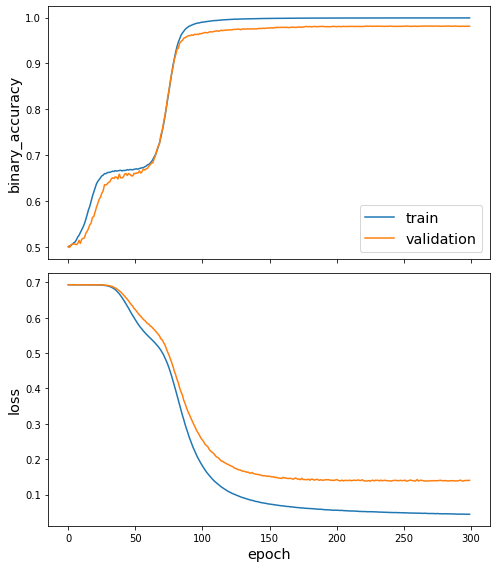

In [10]:
utils.plot_history(wn18_history)

### Evaluate the model

We've now trained a model, so we can apply the evaluation procedure from the paper to it. This is done by taking each test edge `E = (s, r, o)`, and scoring it against all mutations `(s, r, n)` and `(n, r, o)` for every node `n` in the graph, that is, doing a prediction for every one of these edges similar to `E`. The "raw" rank is the number of mutated edges that have a higher predicted score than the true `E`.

The DistMult paper uses only 10 batches per epoch, which results in large batch sizes: ~15 thousand edges per batch for WN18, and ~60 thousand edges per batch for the FB15k dataset below. Evaluation with `rank_edges_against_all_nodes` uses bulk operations for efficient reasons, at the cost of memory usage proportional to `O(batch size * number of nodes)`; a more moderate batch size gives similar performance without using large amounts of memory. We can swap the batch size by creating a new generator.

In [11]:
wn18_smaller_gen = KGTripleGenerator(wn18_graph, batch_size=5000)

wn18_raw_ranks, wn18_filtered_ranks = wn18_distmult.rank_edges_against_all_nodes(
    wn18_smaller_gen.flow(wn18_test), wn18_graph
)

In [12]:
# helper function to compute metrics from an array of ranks
def results_as_dataframe(mrr, hits_at_10):
    return pd.DataFrame(
        [(mrr, hits_at_10)], columns=["mrr", "hits at 10"], index=["filtered"],
    )


def summarise(ranks):
    return results_as_dataframe(np.mean(1 / ranks), np.mean(ranks <= 10))

In [13]:
summarise(wn18_filtered_ranks)

,mrr,hits at 10
filtered,0.709954,0.9303


For comparison, Table 2 in the paper gives the following results for WN18. All of the numbers are similar:

In [14]:
results_as_dataframe(0.83, 0.942)

,mrr,hits at 10
filtered,0.83,0.942


## FB15k

Now that we know the process, we can apply the model on the FB15k dataset in the same way.

### Loading the data

In [15]:
fb15k = datasets.FB15k()
display(HTML(fb15k.description))
fb15k_graph, fb15k_train, fb15k_test, fb15k_valid = fb15k.load()

In [16]:
print(fb15k_graph.info())

StellarDiGraph: Directed multigraph
 Nodes: 14951, Edges: 592213

 Node types:
  default: [14951]
    Features: none
    Edge types: default-/american_football/football_coach/coaching_history./american_football/football_historical_coach_position/position->default, default-/american_football/football_coach/coaching_history./american_football/football_historical_coach_position/team->default, default-/american_football/football_coach_position/coaches_holding_this_position./american_football/football_historical_coach_position/coach->default, default-/american_football/football_coach_position/coaches_holding_this_position./american_football/football_historical_coach_position/team->default, default-/american_football/football_player/current_team./american_football/football_roster_position/position->default, ... (1340 more)

 Edge types:
    default-/award/award_nominee/award_nominations./award/award_nomination/award_nominee->default: [19764]
    default-/film/film/release_date_s./film/film_r

### Train a model

In [17]:
fb15k_gen = KGTripleGenerator(
    fb15k_graph, batch_size=len(fb15k_train) // 10  # ~100 batches per epoch
)

fb15k_distmult = DistMult(
    fb15k_gen,
    embedding_dimension=embedding_dimension,
    embeddings_regularizer=regularizers.l2(1e-8),
)

fb15k_inp, fb15k_out = fb15k_distmult.in_out_tensors()

fb15k_model = Model(inputs=fb15k_inp, outputs=fb15k_out)
fb15k_model.compile(
    optimizer=optimizers.Adam(lr=0.001),
    loss=losses.BinaryCrossentropy(from_logits=True),
    metrics=[metrics.BinaryAccuracy(threshold=0.0)],
)

In [18]:
fb15k_train_gen = fb15k_gen.flow(
    fb15k_train, negative_samples=negative_samples, shuffle=True
)
fb15k_valid_gen = fb15k_gen.flow(fb15k_valid, negative_samples=negative_samples)

In [19]:
fb15k_es = callbacks.EarlyStopping(monitor="val_loss", patience=50)
fb15k_history = fb15k_model.fit(
    fb15k_train_gen,
    validation_data=fb15k_valid_gen,
    epochs=epochs,
    callbacks=[fb15k_es],
    verbose=0,
)

  ['...']
  ['...']


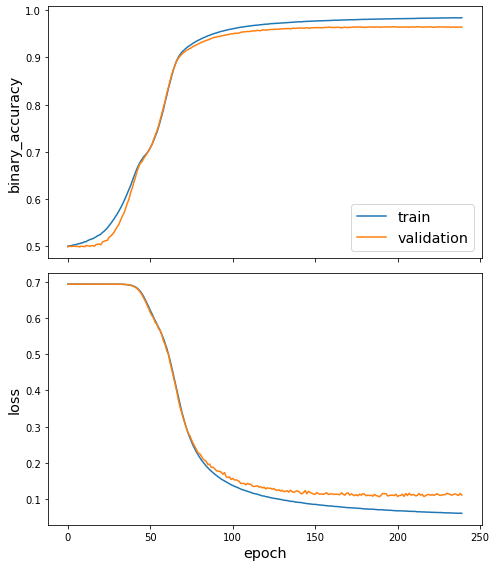

In [20]:
utils.plot_history(fb15k_history)

### Evaluate the model

In [21]:
fb15k_smaller_gen = KGTripleGenerator(fb15k_graph, batch_size=5000)

fb15k_raw_ranks, fb15k_filtered_ranks = fb15k_distmult.rank_edges_against_all_nodes(
    fb15k_smaller_gen.flow(fb15k_test), fb15k_graph
)

In [22]:
summarise(fb15k_filtered_ranks)

,mrr,hits at 10
filtered,0.33919,0.579582


For comparison, Table 2 in the paper gives the following results for FB15k:

In [23]:
results_as_dataframe(0.35, 0.577)

,mrr,hits at 10
filtered,0.35,0.577


<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/link-prediction/distmult-link-prediction.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/link-prediction/distmult-link-prediction.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>